In [1]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pycorrelate
import collections
import itertools
from mpl_toolkits import mplot3d
import cv2
import imutils
import os
from scipy.spatial.transform import Rotation as R

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 1000)
%matplotlib inline

### Step 1: Load Data (and correct glasses time offset to align everything)

In [2]:
metadata = pickle.load(open('./cleaned_data/metadata.p', 'rb'))
print('Please Choose a Session to Work With:')
for k in metadata: print(k, end=',  ')

Please Choose a Session to Work With:
david_2,  patrick_1,  patrick_2,  beata_1,  david_3b,  irmandy_1,  juliana_1,  irmandy_2,  patrick_3,  

In [3]:
SESSION = 'patrick_3'

In [4]:
hand_annotations = pickle.load(open('./cleaned_data/' + SESSION + '/hand_annotations.p', "rb" ))

vid_meta_data = pickle.load(open('./cleaned_data/' + SESSION + '/video_blink_sessions.p', "rb" ))

best_offset = pickle.load(open('./cleaned_data/' + SESSION + '/best_offset.p', "rb" ))

accel_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_accel.p', "rb" ))
for i in range(len(accel_sess)): accel_sess[i]['timestamp_ms'] = accel_sess[i]['timestamp_ms'] + best_offset
    
df_vid = pd.read_csv('./cleaned_data/' + SESSION + '/video_consolidated.csv', index_col=0)
df_vid['timestamp_ms'] = df_vid['est_timestamp_ms']

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Mapping our quaternions to radians in world coordinates at different sample rates

Our part gives us real part plus the imaginary components (all 4), but the magnitude of these we expect to equal 1 (it is not describing a rotation, as is typical for quaternions, but just a 3D orientation).  The same is true of the video quaternions, which don't bother to include the real part since we know it will sum to 1 with the others in magnitude.

The video is at 60Hz, our time aligned data is at 10Hz.  We want to quickly map one to the other to check for quality.

(1) interpolate 60Hz signal to nearest 10Hz.
(2) find a LMS quaternion to mulitply by one of our datasets to give the other
(3) apply it, plot the result, plot the magnitude error at each timestep

In [5]:
# Chop the video into useful sections based on success metric
def df_between_timestamps(df, time_col, start_time, end_time):
    return df[(start_time <= df[time_col]) & (df[time_col] <= end_time)].copy()

def print_summary(df_vid, thresh=0.3):
    old_len = len(df_vid)
    df_vids = len(df_vid[df_vid['success'] == 1])
    print('Have',df_vids, 'frames considered successful, (%2.2f%%)' % (100.*df_vids/old_len))    
    df_vidc = len(df_vid[df_vid['confidence'] >= thresh])
    print('Have',df_vidc, 'frames above thresh of',thresh,'(%2.2f%%)' % (100.*df_vidc/old_len))
    
    return old_len, df_vids

def get_sessions_by_success(df_vid_in, min_sess_sec=0.2, tolerate_n_dropped_frames=2):
    sessions = []
    min_sess_len = min_sess_sec * 60 #samples in min_sess_sec is FPS*sec
    prev_tick = 0
    curr_sess = pd.DataFrame()
    
    old_len = len(df_vid_in)
    df_vid = df_vid_in.copy()
    df_vid = df_vid[df_vid['success'] == 1]
    print('Have',len(df_vid), 'frames considered successful, (%2.2f%%)' % (100.*len(df_vid)/old_len))
    
    #iterate over dataframe only where rows have success == 1
    for i, row in df_vid.iterrows():
        #when we skip a row because tracking failed, append current session
        #if it's long enough and start a new session over
        if row['tick_ms'] > (prev_tick + 24.5 + tolerate_n_dropped_frames*100/6.):
            if len(curr_sess) > min_sess_len:
                sessions.append(curr_sess)
            del curr_sess
            curr_sess = pd.DataFrame()
        
        curr_sess = curr_sess.append(row)
        prev_tick = row['tick_ms']        
        
    if len(curr_sess) > min_sess_len: sessions.append(curr_sess)
    
    return sessions

In [6]:
MIN_SEC_SESSION = 0.2
DROP_FRAMES = 2

print_summary(df_vid)
print('-'*20)
print('USING SUCCESSFUL BY OPENFACE STANDARD')
print('-'*20)
vid_sess = get_sessions_by_success(df_vid, 
                                   min_sess_sec=MIN_SEC_SESSION, 
                                   tolerate_n_dropped_frames=DROP_FRAMES)

print('found',len(vid_sess),'sessions.')

Have 809518 frames considered successful, (84.52%)
Have 814906 frames above thresh of 0.3 (85.08%)
--------------------
USING SUCCESSFUL BY OPENFACE STANDARD
--------------------
Have 809518 frames considered successful, (84.52%)
found 489 sessions.


In [74]:
#we have accel_sess and vid_sess

def align_accel_into_vid(accel_sess, vid_sess):
    #let's accumulate our 10hz accel data into one df
    df_all_accel = pd.concat(accel_sess)
    
    pd.options.mode.chained_assignment = None  # default='warn'
    
    combined_dfs = []
    #now we'll make an array for each vid session
    for v in vid_sess[0:250]:
        #grab accel in that vid_sess
        a = df_between_timestamps(df_all_accel, 
                                  'timestamp_ms', 
                                  v['timestamp_ms'].iloc[0], 
                                  v['timestamp_ms'].iloc[-1])
        #now for each a, interpolate v and append
        for i, row in a.iterrows():
            interpolate_time = row['timestamp_ms']
            v['diff'] = v['timestamp_ms'] - interpolate_time
            
            v_prior = v[v['diff'] == v.loc[v['diff']<=0, 'diff'].max()]
            v_after = v[v['diff'] == v.loc[v['diff']>=0, 'diff'].min()]
            
            weight_prior = abs(v_after['diff'].values[0])
            weight_after = abs(v_prior['diff'].values[0])

            if weight_prior == 0:
                weight_prior = 0
                weight_after = 1
            elif weight_after == 0:
                weight_prior = 1
                weight_after = 0
            else:
                total = weight_prior + weight_after
                weight_prior /= total
                weight_after /= total
            
            try:
                a.loc[i, 'vid_Rx'] = weight_prior*v_prior['pose_Rx'].values[0] + \
                              weight_after*v_after['pose_Rx'].values[0]
                a.loc[i, 'vid_Ry'] = weight_prior*v_prior['pose_Ry'].values[0] + \
                              weight_after*v_after['pose_Ry'].values[0]
                a.loc[i, 'vid_Rz'] = weight_prior*v_prior['pose_Rz'].values[0] + \
                          weight_after*v_after['pose_Rz'].values[0]

            except:
                print('missed one')
                    
        combined_dfs.append(a)
    
    pd.options.mode.chained_assignment = 'warn'
    
    return combined_dfs
        
quat_dfs = align_accel_into_vid(accel_sess, vid_sess)

A simple test to map the glasses frame to the video frame, just using the first timestamp data:

In [75]:
def test_transform(quat_dfs):
    df_flat = pd.concat(quat_dfs)
    
    rot_vid = R.from_rotvec([df_flat.iloc[0][['vid_Rx', 'vid_Ry', 'vid_Rz']].tolist()])
    rot_glass = R.from_quat([df_flat.iloc[0][['quatReal', 'quatI', 'quatJ', 'quatK']].tolist()])
    
    # Ax = B  |  rot_glass * x = rot_vid  |  x = B/A = A^-1 * B
    x = rot_glass.inv() * rot_vid
    
    print('          glass:', rot_glass.as_euler('xyz', degrees=True))
    print('      transform:', x.as_euler('xyz', degrees=True))
    print('                --------')
    print('glass*transform:', (rot_glass*x).as_euler('xyz', degrees=True))
    print('          video:', rot_vid.as_euler('xyz', degrees=True))

def test_transform_array(quat_dfs):
    df_flat = pd.concat(quat_dfs)
    
    rot_vid = R.from_rotvec(df_flat.iloc[0:10][['vid_Rx', 'vid_Ry', 'vid_Rz']])
    rot_glass = R.from_quat(df_flat.iloc[0:10][['quatReal', 'quatI', 'quatJ', 'quatK']])
    
    # Ax = B  |  rot_glass * x = rot_vid  |  x = B/A = A^-1 * B
    x = (rot_glass.inv() * rot_vid).mean()
    
    for i in range(10):
        print('--')
        print('glass*transform:', (rot_glass[i]*x).as_euler('xyz', degrees=True))
        print('            vid:', rot_vid[i].as_euler('xyz', degrees=True))
    
    
    
test_transform(quat_dfs)
test_transform_array(quat_dfs)

          glass: [[-44.18277374  77.87417417 -20.82066121]]
      transform: [[ 76.53154621 -63.13508482 -84.32189364]]
                --------
glass*transform: [[-12.05261243  -9.00381199  -3.18302242]]
          video: [[-12.05261243  -9.00381199  -3.18302242]]
--
glass*transform: [-7.99645731 -0.04599351  6.79591444]
            vid: [-12.05261243  -9.00381199  -3.18302242]
--
glass*transform: [-6.77411351 -4.61005937  1.44846467]
            vid: [-12.47296268  -9.45233951  -3.15536347]
--
glass*transform: [-5.86680421 -5.5349865  -1.57456509]
            vid: [-10.40440967  -8.24017583  -3.4066348 ]
--
glass*transform: [-5.36579149 -6.58007672 -3.07818566]
            vid: [-10.06425251  -7.70987674  -3.54854229]
--
glass*transform: [-5.42210402 -7.42167018 -4.35245911]
            vid: [-8.38001833 -7.60212039 -3.50657836]
--
glass*transform: [-5.76317093 -8.03668817 -5.29478649]
            vid: [-7.76737485 -6.86063048 -3.48099407]
--
glass*transform: [-6.51534046 -8.86529433 

Now we try to do it in a LMS way over all glasses rotations and video rotations

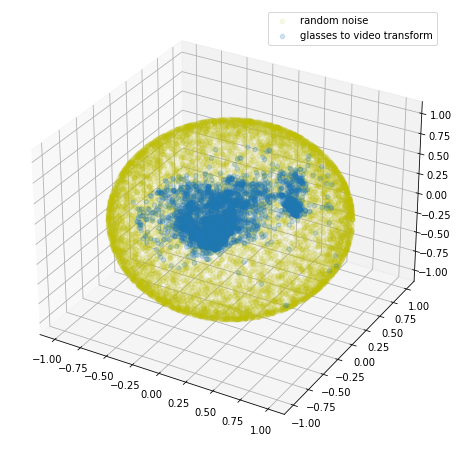

failed for # 0 in quat_array. Len samples: 0
failed for # 1 in quat_array. Len samples: 0
failed for # 2 in quat_array. Len samples: 0
failed for # 3 in quat_array. Len samples: 0
failed for # 4 in quat_array. Len samples: 0
failed for # 5 in quat_array. Len samples: 0


In [89]:
def apply_transform(quat_df_array, by_session=True, technique='avg'):
    
    if not by_session:
        df_flatten = pd.concat(quat_df_array[50:100])
        df_flatten.dropna(inplace=True)
        
        rot_rand = R.random(10000, random_state=1234)
        
        rot_vid   = R.from_rotvec(df_flatten[['vid_Rx', 'vid_Ry', 'vid_Rz']])
        rot_glass = R.from_quat(df_flatten[['quatReal', 'quatI', 'quatJ', 'quatK']])
        # Ax = B  |  rot_glass * x = rot_vid  |  x = B/A = A^-1 * B
        rot_transforms = (rot_glass.inv() * rot_vid)
        
        test_vec = [[1,0,0]]*len(rot_rand)        
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
        data = rot_rand.apply(test_vec)
        ax.scatter3D(data[:,0], data[:,1], data[:,2], alpha=.1, color='y', label='random noise')
        
        
        #should apply to vector [1,0,0] to see what it looks like when plotting rotations
        test_vec = [[1,0,0]]*len(rot_transforms)        
        #fig = plt.figure(figsize=(8,8))
        #ax = plt.axes(projection='3d')
        data = rot_transforms.apply(test_vec)
        #print(data.shape)
        ax.scatter3D(data[:,0], data[:,1], data[:,2], alpha=.2, label='glasses to video transform')
        
        Transform_1 = rot_transforms.mean()
        t1 = Transform_1.apply(test_vec[0])
        #ax.plot3D([0,t1[0]], [0,t1[1]], [0,t1[2]], linewidth=3, label = 'transform 1', color='green')
        
        Transform_2 = R.align_vectors(rot_glass.apply(test_vec), rot_vid.apply(test_vec))
        t2 = Transform_2[0].apply(test_vec[0])
        #ax.plot3D([0,t2[0]], [0,t2[1]], [0,t2[2]], linewidth=3, label = 'transform 2', color='red')
        ax.legend()
        plt.savefig('rotation_alignment.png', dpi=500)
        plt.show()
        
        if technique=='avg': Transform = Transform_1
        else: Transform = Transform_2[0]
        
    for i in range(len(quat_df_array)):
        
        try:
            if by_session:
                rot_vid   = R.from_rotvec(quat_df_array[i][['vid_Rx', 'vid_Ry', 'vid_Rz']])
                rot_glass = R.from_quat(quat_df_array[i][['quatReal', 'quatI', 'quatJ', 'quatK']])
                # Ax = B  |  rot_glass * x = rot_vid  |  x = B/A = A^-1 * B
                if technique=='avg':
                    Transform = (rot_glass.inv() * rot_vid).mean()
                else:
                    test_vec = [[1,0,0]]*len(rot_vid)
                    Transform = R.align_vectors(rot_glass.apply(test_vec), rot_vid.apply(test_vec))[0]
        
            def apply_quat(row):
                return (R.from_quat(row[['quatReal', 'quatI','quatJ', 'quatK']].tolist())*Transform).as_euler('xyz').tolist()

            quat_results = pd.DataFrame(quat_df_array[i].apply(apply_quat, axis=1).to_list(), columns = ['glasses_Rx', 'glasses_Ry', 'glasses_Rz'])

            quat_df_array[i].reset_index(drop=True, inplace=True)
            quat_df_array[i] = pd.concat([quat_df_array[i], quat_results], axis=1)
        except:
            print('failed for #',i,'in quat_array. Len samples:', len(quat_df_array[i]))
    return quat_df_array


temp_quat_dfs = quat_dfs.copy()
new_quat_dfs = apply_transform(temp_quat_dfs, by_session=False)

In [93]:
df_flatten = pd.concat(quat_dfs[50:100])
df_flatten.dropna(inplace=True)

rot_vid   = R.from_rotvec(df_flatten[['vid_Rx', 'vid_Ry', 'vid_Rz']])
rot_glass = R.from_quat(df_flatten[['quatReal', 'quatI', 'quatJ', 'quatK']])
# Ax = B  |  rot_glass * x = rot_vid  |  x = B/A = A^-1 * B
rot_transforms = (rot_glass.inv() * rot_vid)

test_vec = [[1,0,0]]*len(rot_transforms)        
data = rot_transforms.as_euler('xyz', degrees=True)
print(data[0])

[ 21.36703625 -47.58480235 -37.29225193]


In [100]:
xs = np.array([d[0] for d in data])
ys = np.array([d[1] for d in data])
zs = np.array([d[2] for d in data])

print(np.mean(xs))
print(np.mean(ys))
print(np.mean(zs))
print(np.std(xs))
print(np.std(ys))
print(np.std(zs))

48.04380772284985
-35.65767465359314
-61.06678426168073
20.382976850941997
9.785719273470711
22.24476234769711
50.08309626459336


In [97]:
(20.3+9.8+22.2) / 3

17.433333333333334

In [58]:
new_quat_dfs[0].head()

,timestamp_ms,quatI,quatJ,quatK,quatReal,quatRadianAccuracy


IndexError: single positional indexer is out-of-bounds

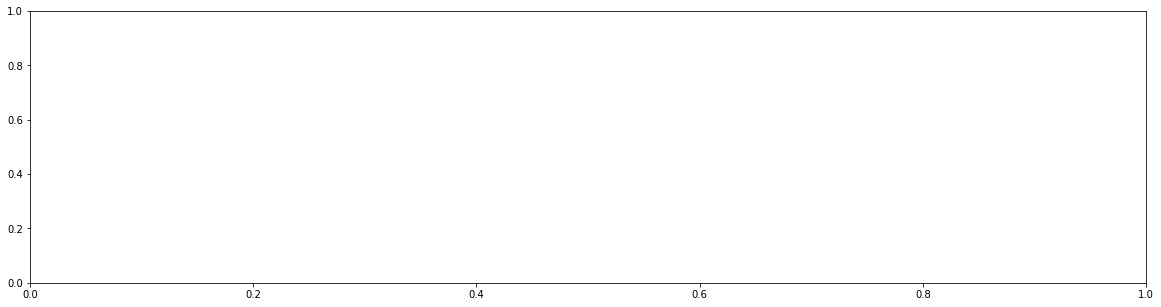

In [14]:
for sess in new_quat_dfs:
    fig, ax = plt.subplots(figsize=(20,5))
      
    ax.plot((sess['timestamp_ms'] - sess['timestamp_ms'].iloc[0])/60000, sess['vid_Rx'], label='video x')
    ax.plot((sess['timestamp_ms'] - sess['timestamp_ms'].iloc[0])/60000, sess['vid_Ry'], label='video y')
    ax.plot((sess['timestamp_ms'] - sess['timestamp_ms'].iloc[0])/60000, sess['vid_Rz'], label='video z')
    
    ax.plot((sess['timestamp_ms'] - sess['timestamp_ms'].iloc[0])/60000, sess['glasses_Rx'], label='glass x')
    ax.plot((sess['timestamp_ms'] - sess['timestamp_ms'].iloc[0])/60000, sess['glasses_Ry'], label='glass y')
    ax.plot((sess['timestamp_ms'] - sess['timestamp_ms'].iloc[0])/60000, sess['glasses_Rz'], label='glass z')
    
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Euler angles (rad)')
    ax.set_title('Accelerometer Data vs Video Motion Data; LMS translation')
    ax.legend()
    
    #plt.savefig('blinkdata_juliana2.png', dpi=500)
    plt.show()

In [ ]:
#IMU direct, rot_tick is tick that IMU triggers interrupt and grabs, within ms

# (1) blink align based off of raw timestamps minimize
# (2) IMU rot_tick timestamp
# (3) write a function that play the video snippet working on
# (4) check time alignment between blink binary vs continuous
